# Distance Analysis: oralcavity-codex-czi

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `oralcavity-codex-czi` dataset.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from _cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "oralcavity-codex-czi"
data_filedir = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir)
output_edge_dir = os.path.join("data-processed-edges", dataset_dir)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
df_all_nodes, df_all_edges, df_all_edges_with_cell_types = read_all_edge_datasets(basepath, data_filedir, output_edge_dir)

In [7]:
df_all_nodes.head(5)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,2466.85,580.95,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
1,2421.30,629.05,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
2,2459.00,681.80,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
3,2418.20,700.00,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
4,2444.70,768.30,Treg,t cell:regulatory,regulatory T cell,CL:0000815,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 39
Level Three Cell Type: 28
Level Two Cell Type: 20
Level One Cell Type: 6


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:
  - Vascular Endothelial Cells
  - Lymphatic Endothelial Cells

Level Three Cell Type:
  - endothelial cell of vascular tree
  - endothelial cell of lymphatic vessel

Level Two Cell Type:
  - endothelial cell of vascular tree
  - endothelial cell of lymphatic vessel

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell of vascular tree',
    'Level Two Cell Type': 'endothelial cell of vascular tree',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
# Create a dictionary to map oral cavity regions to correct region names.
region_map = {'Buccal_Mucosa_And_Minor_Salivary_Glands_1':'Buccal Mucosa And Minor Salivary Glands',
 'Buccal_Mucosa_And_Minor_Salivary_Glands_2':'Buccal Mucosa And Minor Salivary Glands', 
 'Gingiva_ID1_shiny':'Gingiva',
 'Gingiva_ID5_shiny':'Gingiva', 
 'Parotid_1':'Parotid', 
 'Parotid_2':'Parotid', 
 'Parotid_3':'Parotid', 
 'Parotid_4':'Parotid',
 'Submandibular_1':'Submandibular', 
 'Submandibular_2':'Submandibular', 
 'Tongue_3':'Tongue', 
 'Tongue__1':'Tongue', 
 'Tongue__2':'Tongue'
}

In [12]:
df_all_nodes.head()

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,2466.85,580.95,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
1,2421.30,629.05,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
2,2459.00,681.80,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
3,2418.20,700.00,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1
4,2444.70,768.30,Treg,t cell:regulatory,regulatory T cell,CL:0000815,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1


In [13]:
# Iterate through the df_all_data dataframe to create new column "Unique Region" based on the "Dataset" column.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].map(region_map)
# df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].str.split('-').str[1].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
1,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
2,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
3,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
4,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands


In [14]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_nodes['Unique Region'].unique():
    num_datasets = df_all_nodes[df_all_nodes['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['Buccal Mucosa And Minor Salivary Glands' 'Gingiva' 'Parotid'
 'Submandibular' 'Tongue']
Total number of unique regions: 5

Number of unique datasets per unique region:
Buccal Mucosa And Minor Salivary Glands: 2
Gingiva: 2
Parotid: 4
Submandibular: 2
Tongue: 3


## Process datasets to add region information to Edges files.

In [15]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level
0,0,2466.85,580.950,0,2600.55,598.700,0,134.873098,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type
1,759,2595.45,407.850,0,2689.10,404.285,0,93.717830,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type
2,782,2599.45,413.290,0,2689.10,404.285,0,90.101124,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type
3,840,2588.60,414.555,0,2689.10,404.285,0,101.023378,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type
4,869,2583.50,419.190,0,2689.10,404.285,0,106.646702,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type


In [16]:
# Process the edge data to create new columns "Unique Region" based on the "Dataset" column, similar to how it was done for the node data.
df_all_edges['Unique Region'] = df_all_edges['Dataset'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
1,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
2,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
3,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
4,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands


In [17]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_edges['Unique Region'].unique():
    num_datasets = df_all_edges[df_all_edges['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['Buccal Mucosa And Minor Salivary Glands' 'Gingiva' 'Parotid'
 'Submandibular' 'Tongue']
Total number of unique regions: 5

Number of unique datasets per unique region:
Buccal Mucosa And Minor Salivary Glands: 2
Gingiva: 2
Parotid: 4
Submandibular: 2
Tongue: 3


In [18]:
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
1,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
2,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
3,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands
4,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands


In [19]:
df_all_nodes.head(1)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Unique Region
0,2466.85,580.95,Others,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,unknown cell,cell:unknown,CL:0000000,skos:narrowMatch,Buccal_Mucosa_And_Minor_Salivary_Glands_1,Buccal Mucosa And Minor Salivary Glands


In [20]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Unique Region
0,0,2466.85,580.95,0,2600.55,598.7,0,134.873098,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type,Buccal Mucosa And Minor Salivary Glands


In [21]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Unique Region
0,0,2466.85,580.95,0,2600.55,598.7,0,134.873098,Buccal_Mucosa_And_Minor_Salivary_Glands_1,endothelial cell of vascular tree,Level Three Cell Type,unknown cell,unknown cell,unknown cell,Buccal Mucosa And Minor Salivary Glands


## Node Analysis

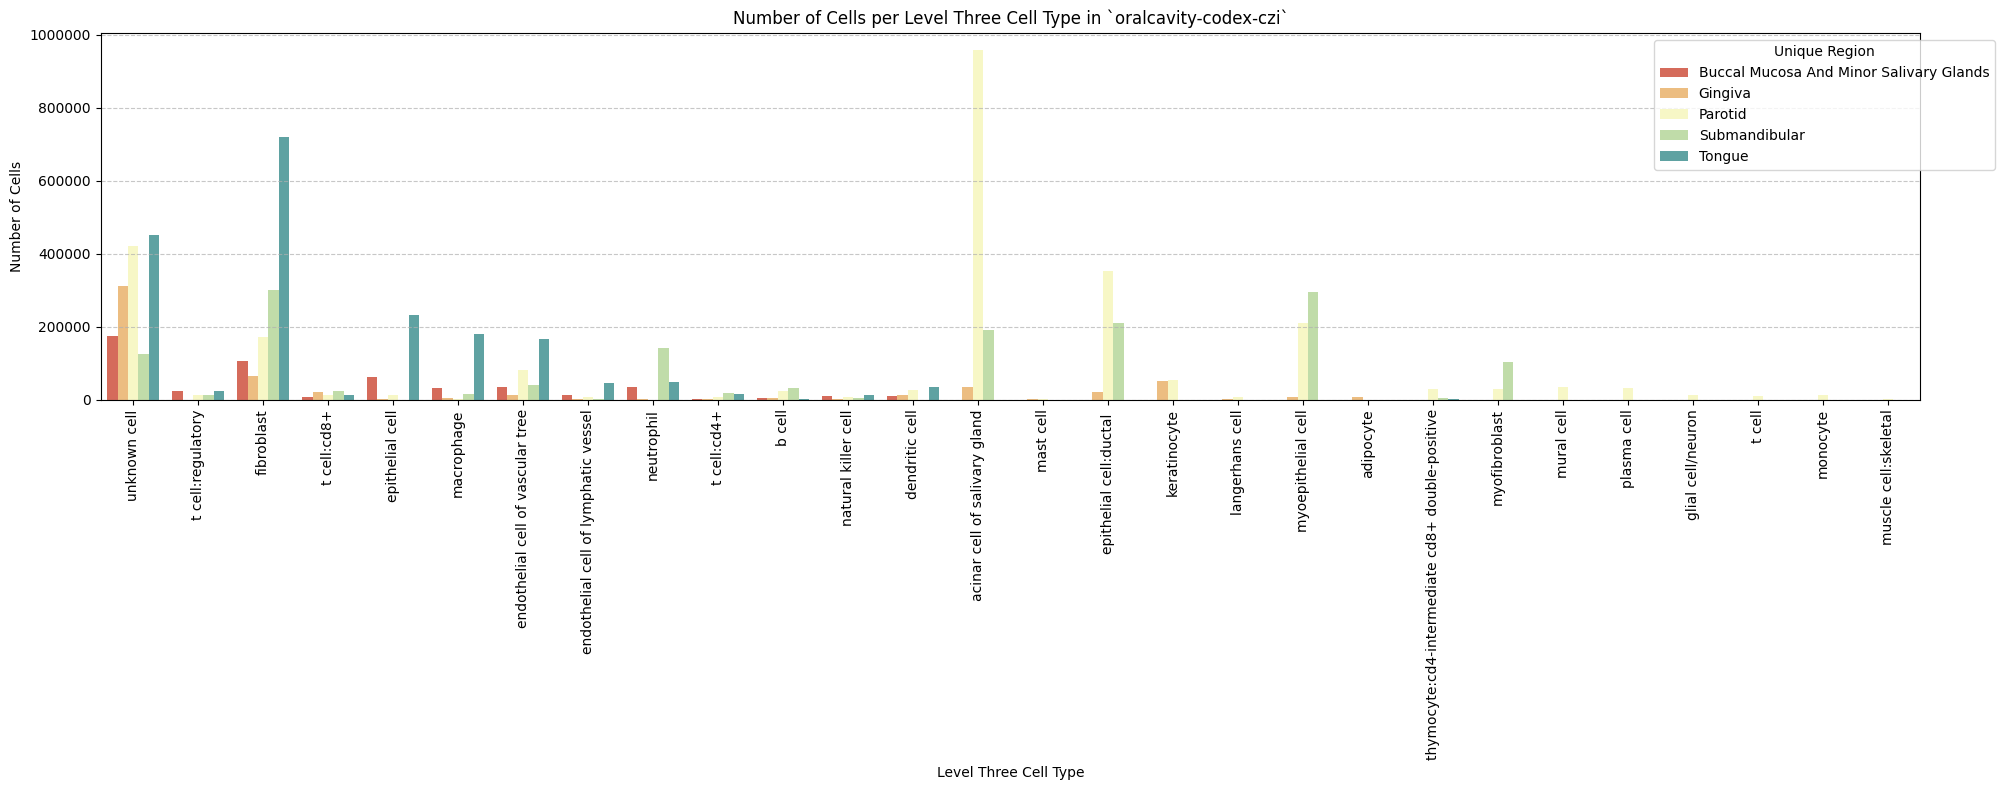

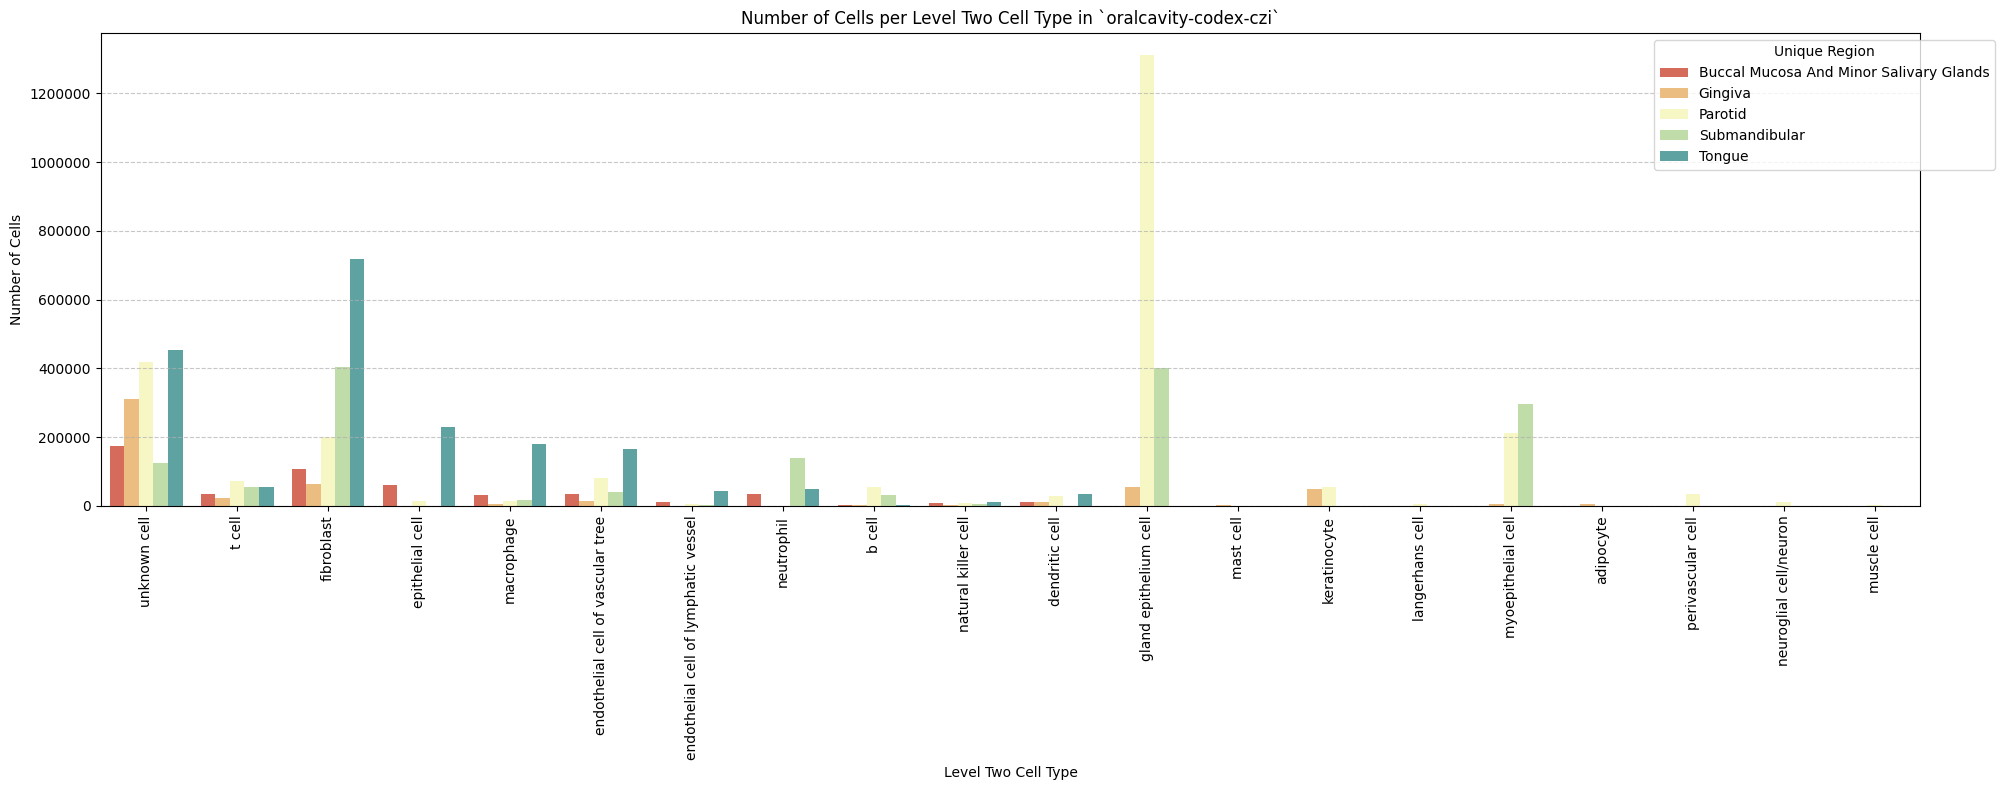

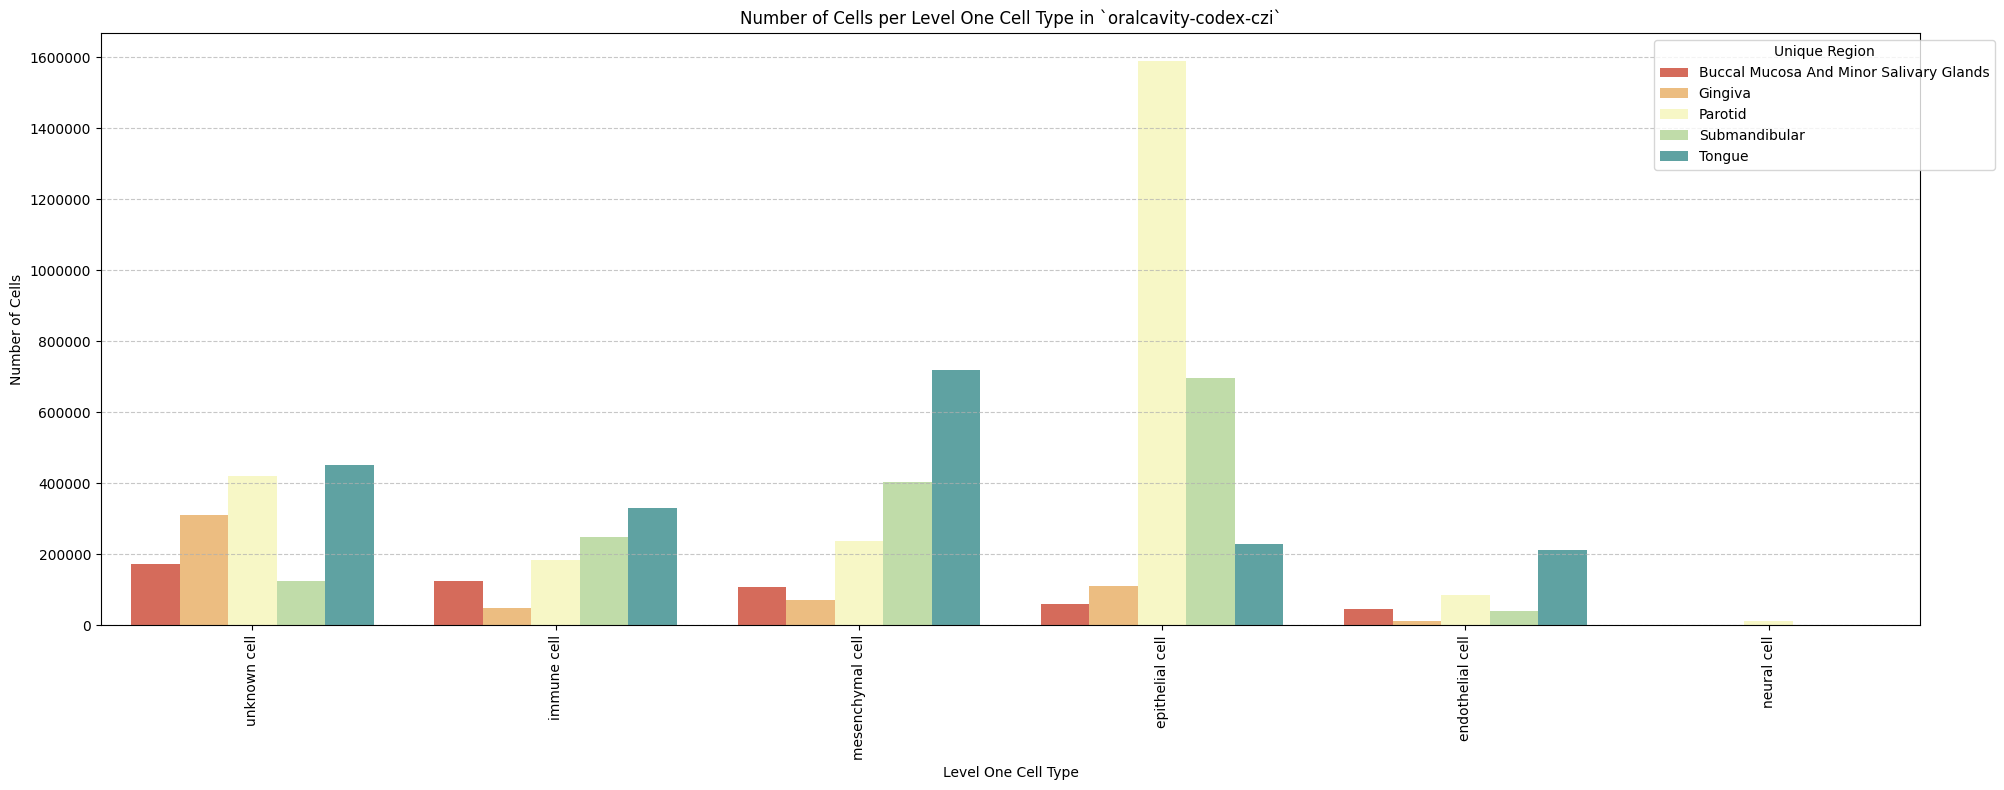

In [22]:
# Plot number of cells per cell type in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, output_dir):
    plt.figure(figsize=(20, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.countplot(data=df, x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in `{dataset_dir}`')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)

    # For numbers on y-axis, do not use scientific notation.
    plt.ticklabel_format(style='plain', axis='y')
    # Set y-axis label
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [23]:
# Get mean, median, minimum, maximum distance per unique region per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,Buccal Mucosa And Minor Salivary Glands,endothelial cell,Level One Cell Type,32.788252,22.583456,2.350532,199.920297
1,Buccal Mucosa And Minor Salivary Glands,endothelial cell of lymphatic vessel,Level Three Cell Type,66.570639,56.315739,2.400521,199.999181
2,Buccal Mucosa And Minor Salivary Glands,endothelial cell of lymphatic vessel,Level Two Cell Type,66.570639,56.315739,2.400521,199.999181
3,Buccal Mucosa And Minor Salivary Glands,endothelial cell of vascular tree,Level Three Cell Type,41.164970,28.331828,2.350532,199.920297
4,Buccal Mucosa And Minor Salivary Glands,endothelial cell of vascular tree,Level Two Cell Type,41.164970,28.331828,2.350532,199.920297
5,Gingiva,endothelial cell,Level One Cell Type,46.035025,35.977739,0.006517,199.932087
6,Gingiva,endothelial cell of lymphatic vessel,Level Three Cell Type,118.082543,121.622867,0.466601,199.993077
7,Gingiva,endothelial cell of lymphatic vessel,Level Two Cell Type,118.082543,121.622867,0.466601,199.993077
8,Gingiva,endothelial cell of vascular tree,Level Three Cell Type,46.818074,36.442616,0.006517,199.932087
9,Gingiva,endothelial cell of vascular tree,Level Two Cell Type,46.818074,36.442616,0.006517,199.932087


### Level One Cell Type Analysis

In [24]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,epithelial cell,Buccal Mucosa And Minor Salivary Glands,47.227324,39.939347,2.451530,199.035857
1,epithelial cell,Gingiva,44.140615,34.768144,0.010330,199.836547
2,epithelial cell,Parotid,26.585115,22.840156,0.017954,199.947587
3,epithelial cell,Submandibular,23.907224,20.577384,2.755449,199.833787
4,epithelial cell,Tongue,85.775049,79.378846,2.815138,199.990006
5,immune cell,Buccal Mucosa And Minor Salivary Glands,24.581746,18.289273,2.400521,198.825866
6,immune cell,Gingiva,52.854768,40.612195,0.029228,199.932087
7,immune cell,Parotid,29.196625,22.425217,0.004528,199.996540
8,immune cell,Submandibular,27.443867,22.173182,2.549510,190.454122
9,immune cell,Tongue,26.795128,18.708086,2.800446,199.876143


In [25]:
# Get top five and bottom five cell types with respect to mean distance in each unique region separately.
def get_top_bottom_cell_types_by_mean(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in Buccal Mucosa And Minor Salivary Glands:
  Level One Cell Type  mean_distance
0     epithelial cell      47.227324
3        unknown cell      37.841632
2    mesenchymal cell      25.865052
1         immune cell      24.581746

Bottom 5 cell types in Buccal Mucosa And Minor Salivary Glands:
  Level One Cell Type  mean_distance
0     epithelial cell      47.227324
3        unknown cell      37.841632
2    mesenchymal cell      25.865052
1         immune cell      24.581746

Top 5 cell types in Gingiva:
  Level One Cell Type  mean_distance
1         immune cell      52.854768
3        unknown cell      46.744610
0     epithelial cell      44.140615
2    mesenchymal cell      41.454674

Bottom 5 cell types in Gingiva:
  Level One Cell Type  mean_distance
1         immune cell      52.854768
3        unknown cell      46.744610
0     epithelial cell      44.140615
2    mesenchymal cell      41.454674

Top 5 cell types in Parotid:
  Level One Cell Type  mean_distance
4  

In [26]:
# Get top five and bottom five cell types with respect to median distance in each unique region separately.
def get_top_bottom_cell_types_by_median(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)

    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in Buccal Mucosa And Minor Salivary Glands:
  Level One Cell Type  median_distance
0     epithelial cell        39.939347
3        unknown cell        25.530619
2    mesenchymal cell        18.751667
1         immune cell        18.289273

Bottom 5 cell types in Buccal Mucosa And Minor Salivary Glands:
  Level One Cell Type  median_distance
0     epithelial cell        39.939347
3        unknown cell        25.530619
2    mesenchymal cell        18.751667
1         immune cell        18.289273

Top 5 cell types in Gingiva:
  Level One Cell Type  median_distance
1         immune cell        40.612195
3        unknown cell        36.358142
0     epithelial cell        34.768144
2    mesenchymal cell        34.134295

Bottom 5 cell types in Gingiva:
  Level One Cell Type  median_distance
1         immune cell        40.612195
3        unknown cell        36.358142
0     epithelial cell        34.768144
2    mesenchymal cell        34.134295

Top 5 cell types in Parotid:


In [27]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                                          mean    std  CV (%)
Unique Region                                                
Buccal Mucosa And Minor Salivary Glands  32.79  30.43    92.8
Gingiva                                  46.04  35.92    78.0
Parotid                                  27.29  20.14    73.8
Submandibular                            30.27  25.72    85.0
Tongue                                   37.32  34.85    93.4

Cell Type Variability Analysis (sorted by CV):
                      mean    std  CV (%)
Level One Cell Type                      
epithelial cell      31.24  27.49    88.0
unknown cell         33.97  29.68    87.4
immune cell          28.45  24.84    87.3
mesenchymal cell     35.45  30.49    86.0
neural cell          24.03  18.50    77.0


In [28]:
# Define the standard region sequence for plots
regions = ['Gingiva', 'Submandibular', 'Parotid', 'Tongue', 'Buccal Mucosa And Minor Salivary Glands']

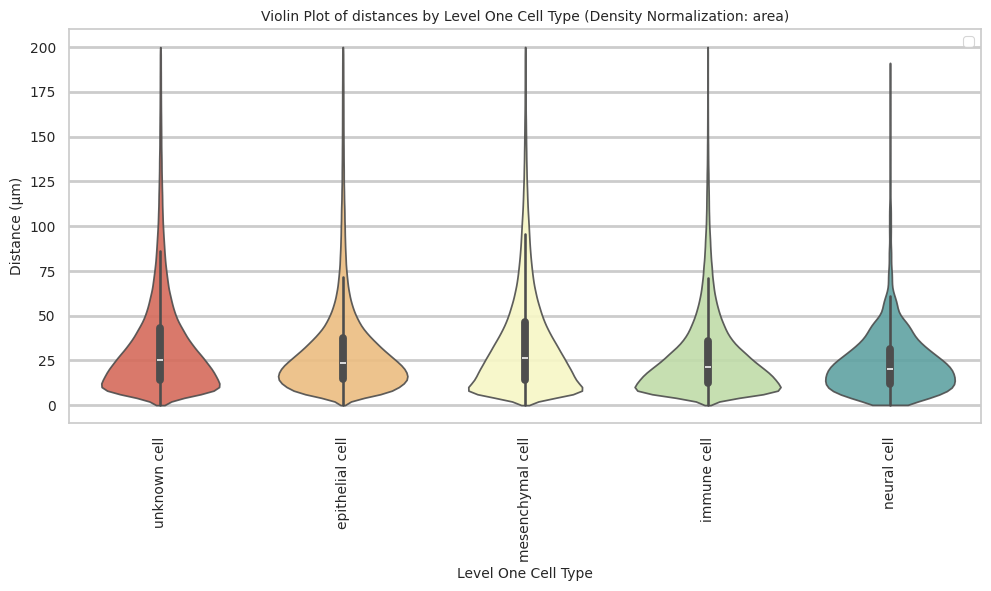

In [29]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm='area'):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 6))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette='Spectral', alpha=.9)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.title(f'Violin Plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

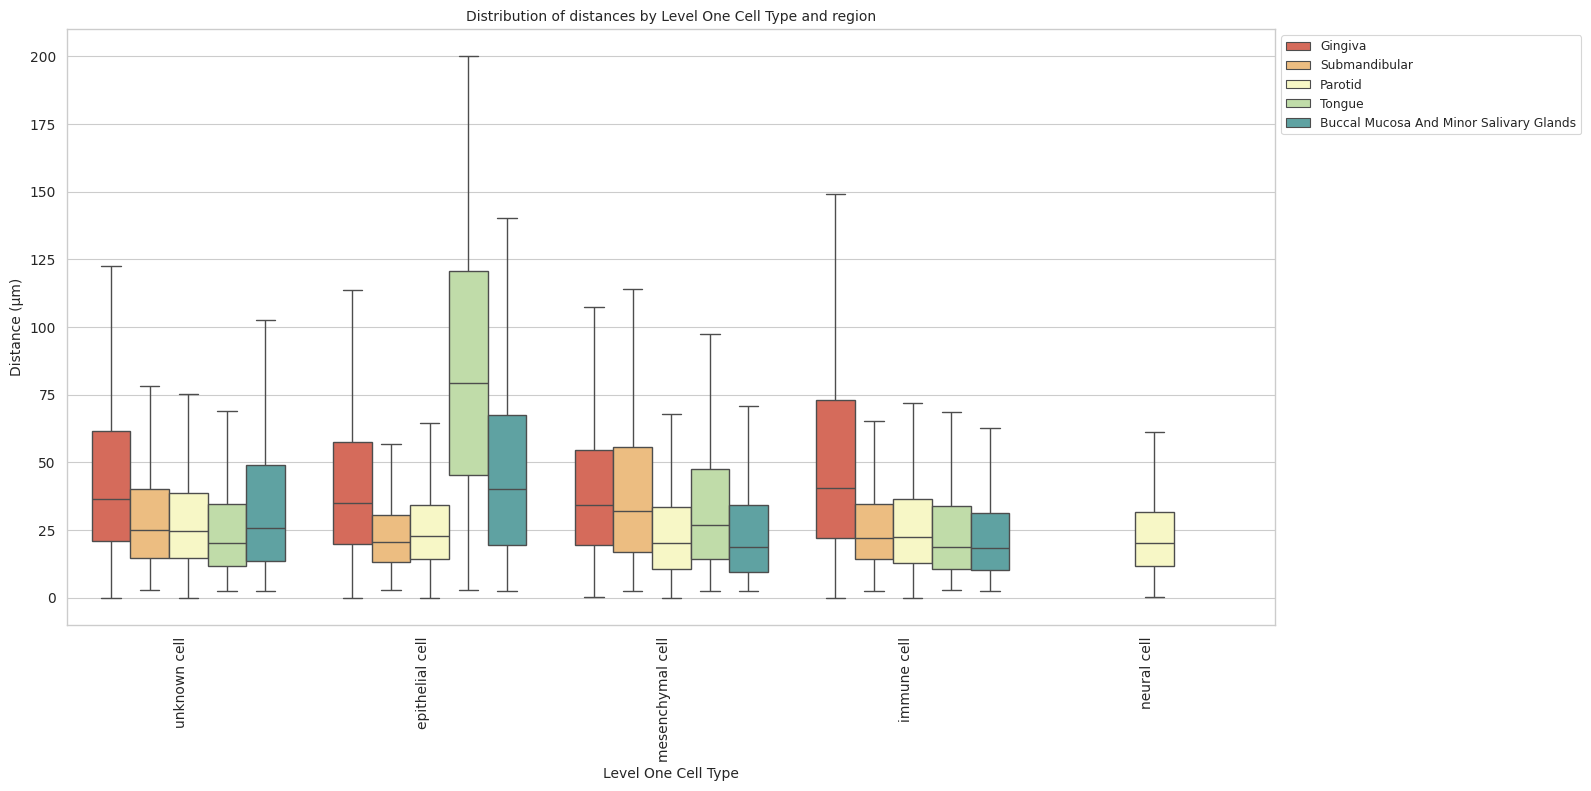

In [30]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(16, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    # Make box plot.
    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.title(f'Distribution of distances by {cell_type_level} and region', fontsize=font_size)
    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

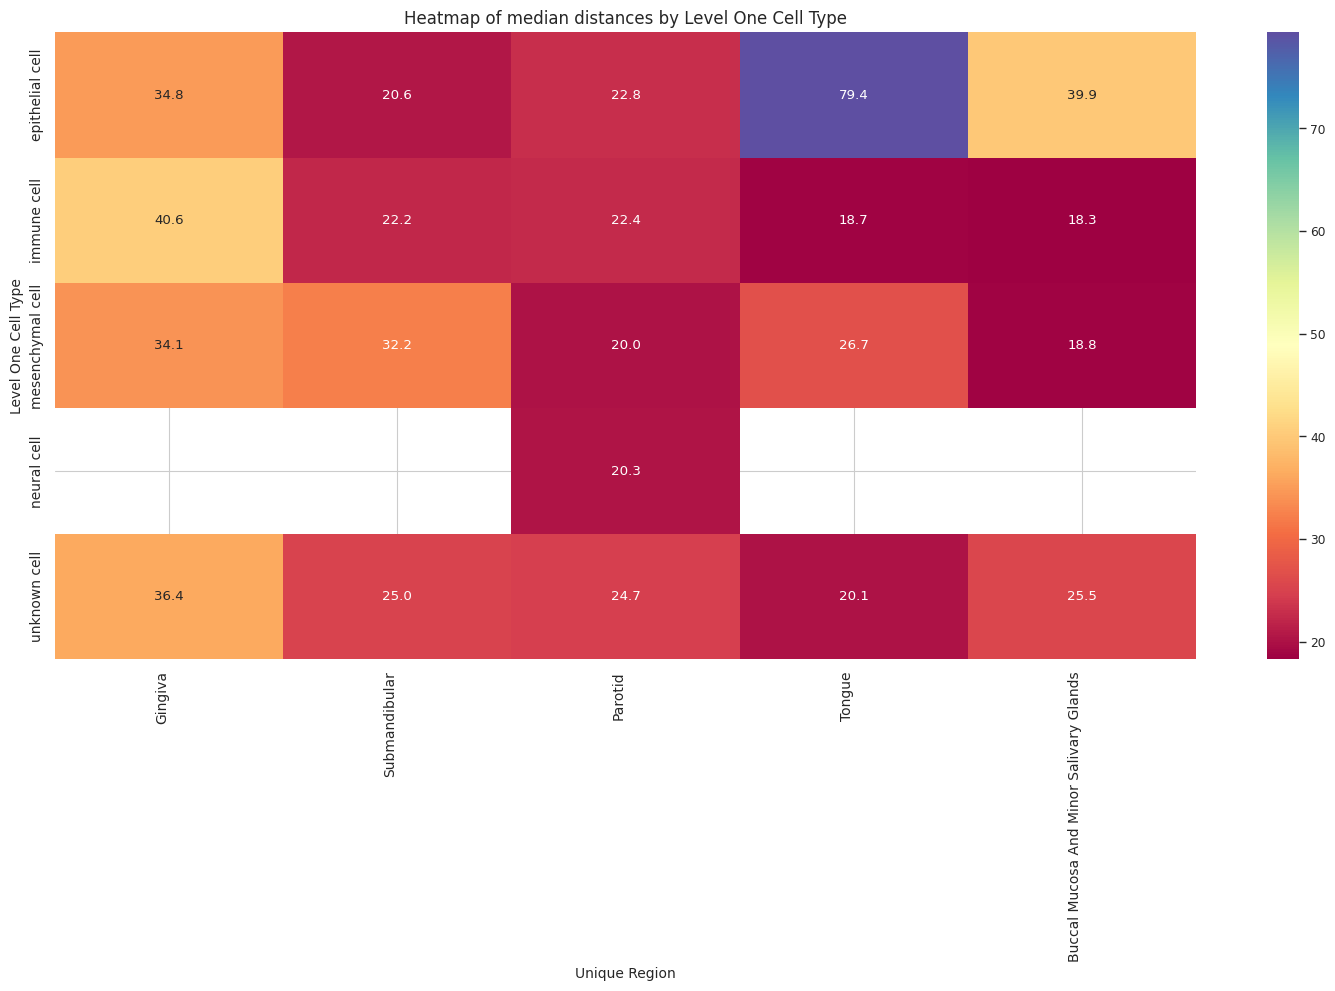

In [31]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title(f'Heatmap of median distances by {cell_type_level}', fontsize=12)

    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel('Unique Region', fontsize=font_size)
    plt.ylabel(f'{cell_type_level}', fontsize=font_size)
    
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

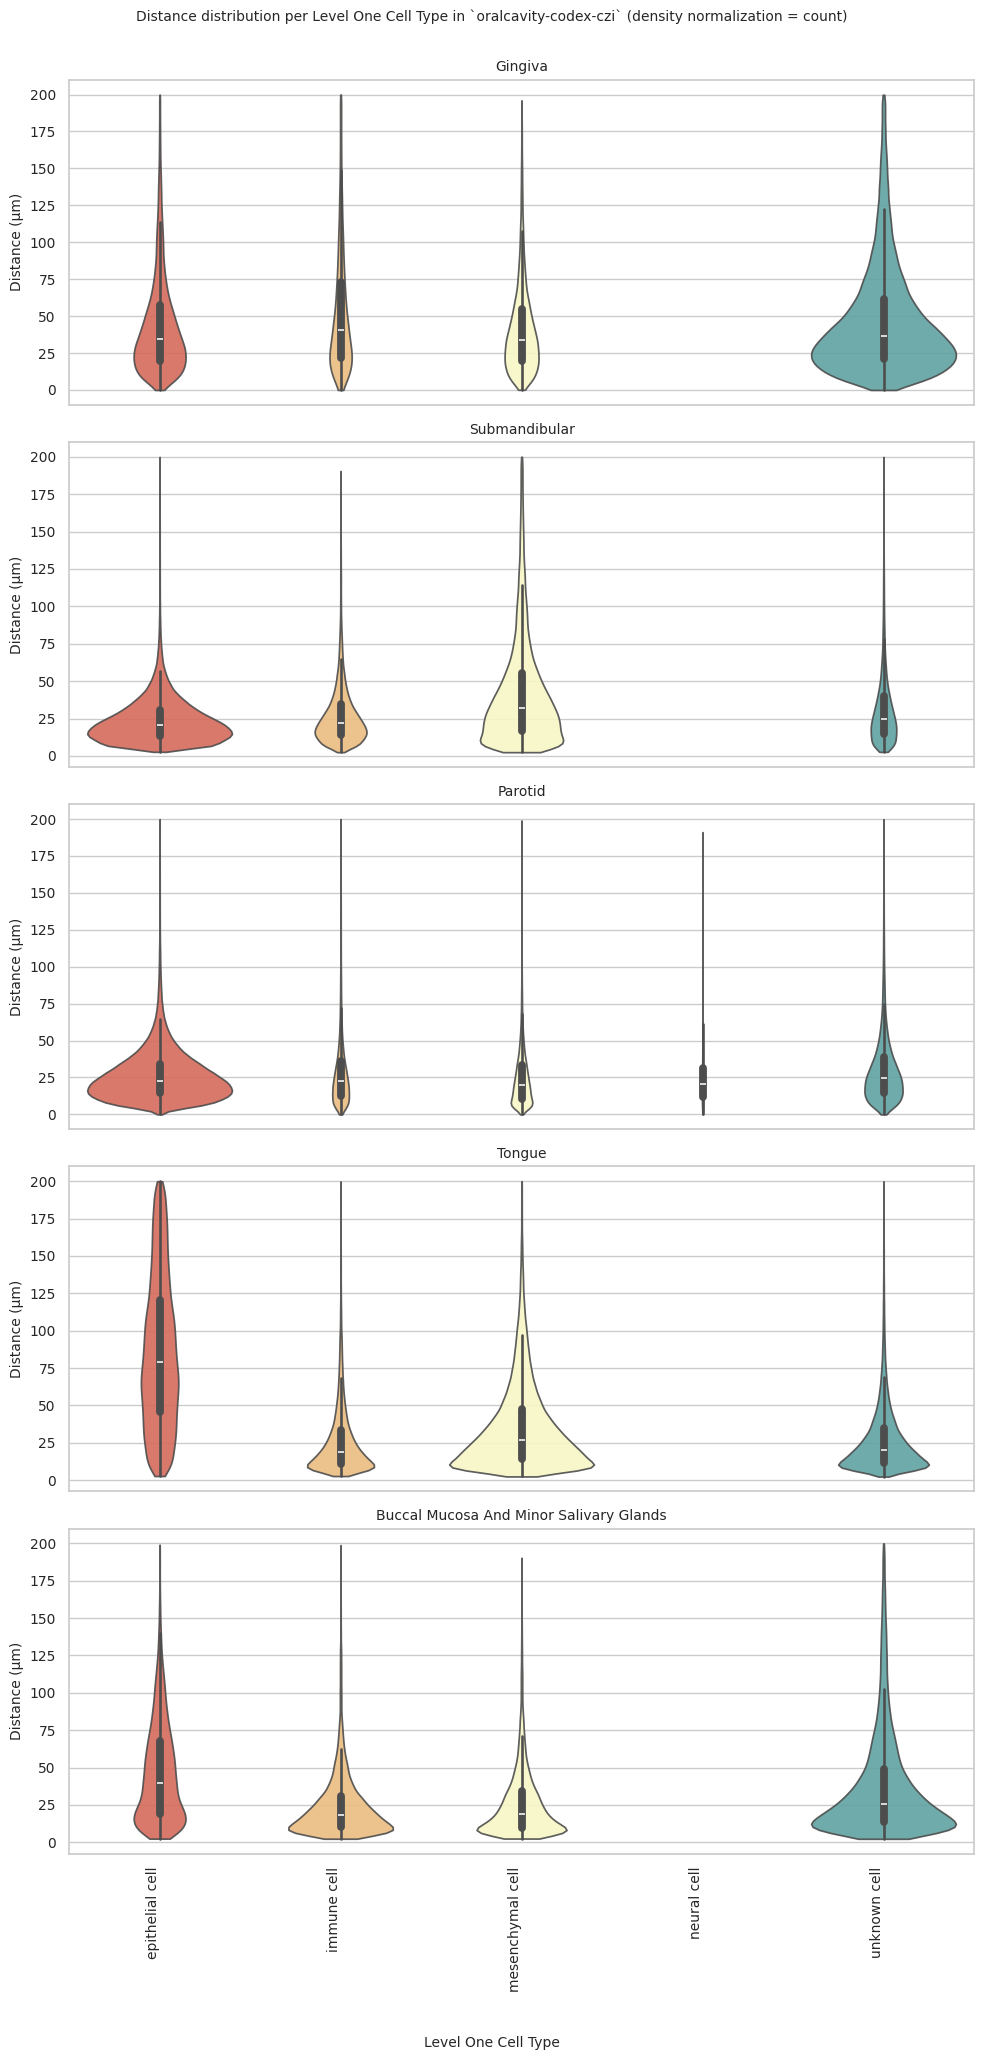

In [32]:
# Generate Violin Plot per unique region in both small intestine and large intestine. Create for all 8 regions as 8 subplots.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    font_size = 10
    fig, axs = plt.subplots(5, 1, figsize=(10, 20)) # Adjusted figsize for horizontal layout
    fig.suptitle(f'Distance distribution per {cell_type_level} in `{dataset_dir}` (density normalization = {density_norm})', fontsize=font_size, y=1)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i].set_title(region, fontsize=font_size)
        axs[i].set_xlabel('', fontsize=font_size)
        axs[i].set_ylabel('Distance (\u03bcm)', fontsize=font_size)
        # axs[i].tick_params(axis='x', labelrotation=90, labelsize=font_size)
        # only show xtick labels for the last subplot
        if i < len(regions) - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticklabels(cell_types, fontsize=font_size, rotation=90, ha='right')
        # axs[i].set_ylim(0, data_reg['Distance'].max() * 1.1)  # Set y-limits to be consistent across all plots
        axs[i].tick_params(axis='both', labelsize=font_size)

    # Use fig.text for precise label positioning
    fig.figure.text(0.5, -0.02, f'{cell_type_level}', ha='center', va='bottom', fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Two Cell Type Analysis

In [33]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,adipocyte,Gingiva,38.921484,31.576881,1.472765,198.358252
1,b cell,Buccal Mucosa And Minor Salivary Glands,23.196496,22.353669,2.804015,98.284549
2,b cell,Gingiva,38.913598,29.370338,1.271453,198.729570
3,b cell,Parotid,22.649857,19.314031,0.004528,195.393503
4,b cell,Submandibular,49.468888,45.465234,3.304921,184.012207
5,b cell,Tongue,23.064363,15.471976,3.696282,119.542137
6,dendritic cell,Buccal Mucosa And Minor Salivary Glands,23.820644,19.333714,2.753634,176.453535
7,dendritic cell,Gingiva,53.327090,40.886464,0.225297,199.932087
8,dendritic cell,Parotid,21.289953,19.328978,0.050563,154.155788
9,dendritic cell,Tongue,49.187117,32.105607,3.162278,199.890432


In [34]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in Buccal Mucosa And Minor Salivary Glands:
   Level Two Cell Type  mean_distance
3      epithelial cell      69.005527
6  natural killer cell      46.769140
9         unknown cell      42.374333
8               t cell      38.797999
4           fibroblast      35.795373

Bottom 5 cell types in Buccal Mucosa And Minor Salivary Glands:
                    Level Two Cell Type  mean_distance
2  endothelial cell of lymphatic vessel      31.266348
7                            neutrophil      30.028958
5                            macrophage      25.882874
1                        dendritic cell      23.820644
0                                b cell      23.196496

Top 5 cell types in Gingiva:
                     Level Two Cell Type  mean_distance
14                                t cell      61.869930
7                           keratinocyte      53.520737
2                         dendritic cell      53.327090
3   endothelial cell of lymphatic vessel      51.530766
4    

In [35]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])



Top 5 cell types in Buccal Mucosa And Minor Salivary Glands:
   Level Two Cell Type  median_distance
3      epithelial cell        63.242607
6  natural killer cell        37.025667
9         unknown cell        28.831450
8               t cell        28.289618
4           fibroblast        25.141972

Bottom 5 cell types in Buccal Mucosa And Minor Salivary Glands:
                    Level Two Cell Type  median_distance
2  endothelial cell of lymphatic vessel        23.013311
0                                b cell        22.353669
7                            neutrophil        21.579446
5                            macrophage        20.110103
1                        dendritic cell        19.333714

Top 5 cell types in Gingiva:
                     Level Two Cell Type  median_distance
14                                t cell        49.247660
3   endothelial cell of lymphatic vessel        47.521442
7                           keratinocyte        42.797847
2                         den

In [36]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                                          mean    std  CV (%)
Unique Region                                                
Buccal Mucosa And Minor Salivary Glands  41.16  37.14    90.2
Gingiva                                  46.82  36.63    78.2
Parotid                                  28.23  21.27    75.3
Submandibular                            30.94  26.10    84.4
Tongue                                   48.57  44.56    91.7

Cell Type Variability Analysis (sorted by CV):
                                       mean    std  CV (%)
Level Two Cell Type                                       
dendritic cell                        37.36  37.48   100.3
macrophage                            32.67  30.91    94.6
fibroblast                            44.68  39.07    87.4
unknown cell                          36.94  31.98    86.6
mast cell 

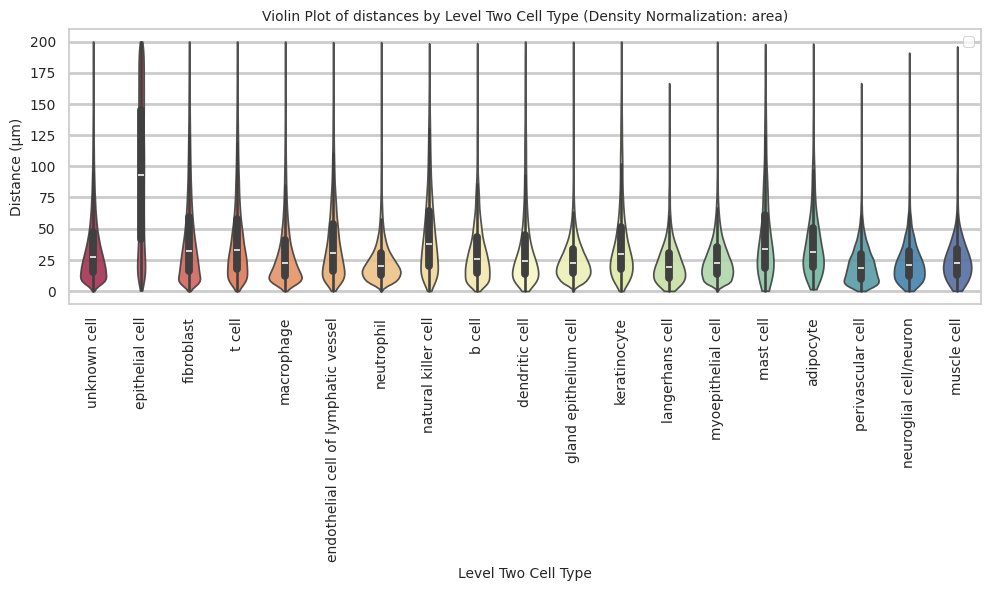

In [37]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

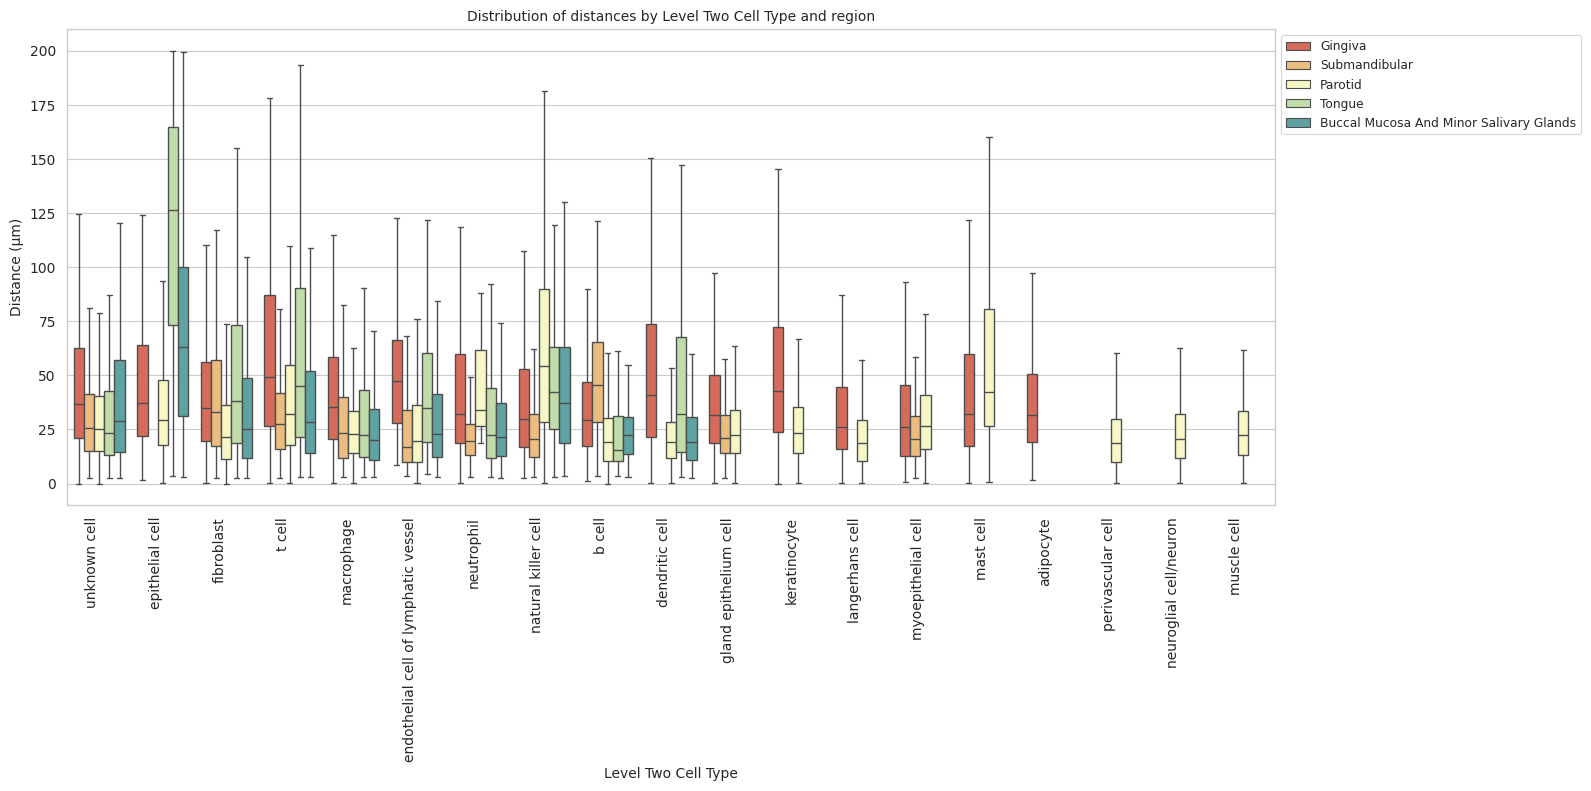

In [38]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

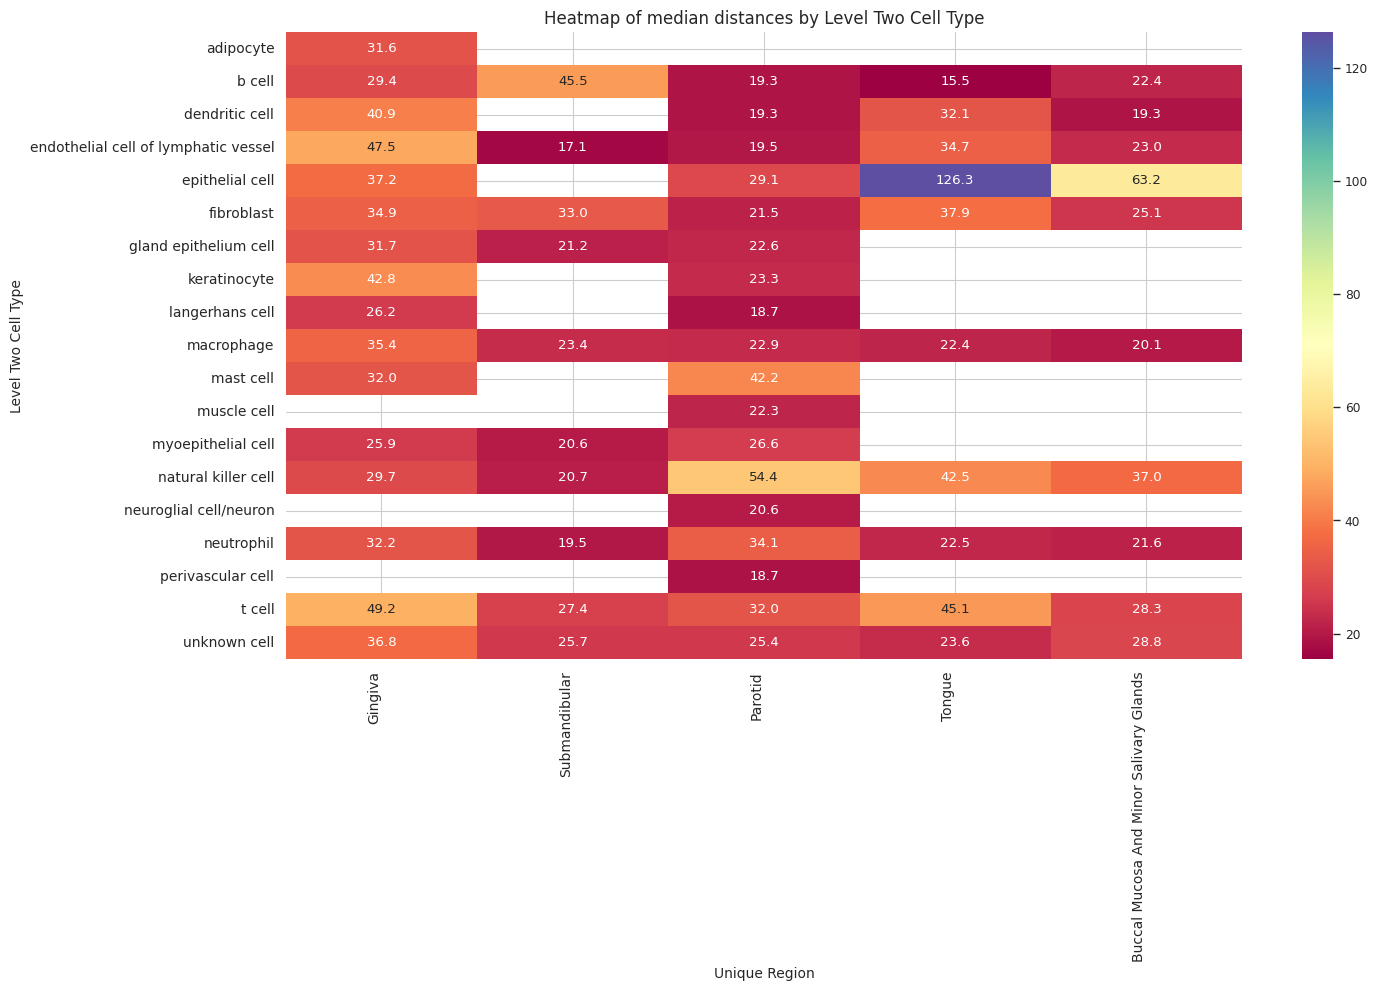

In [39]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

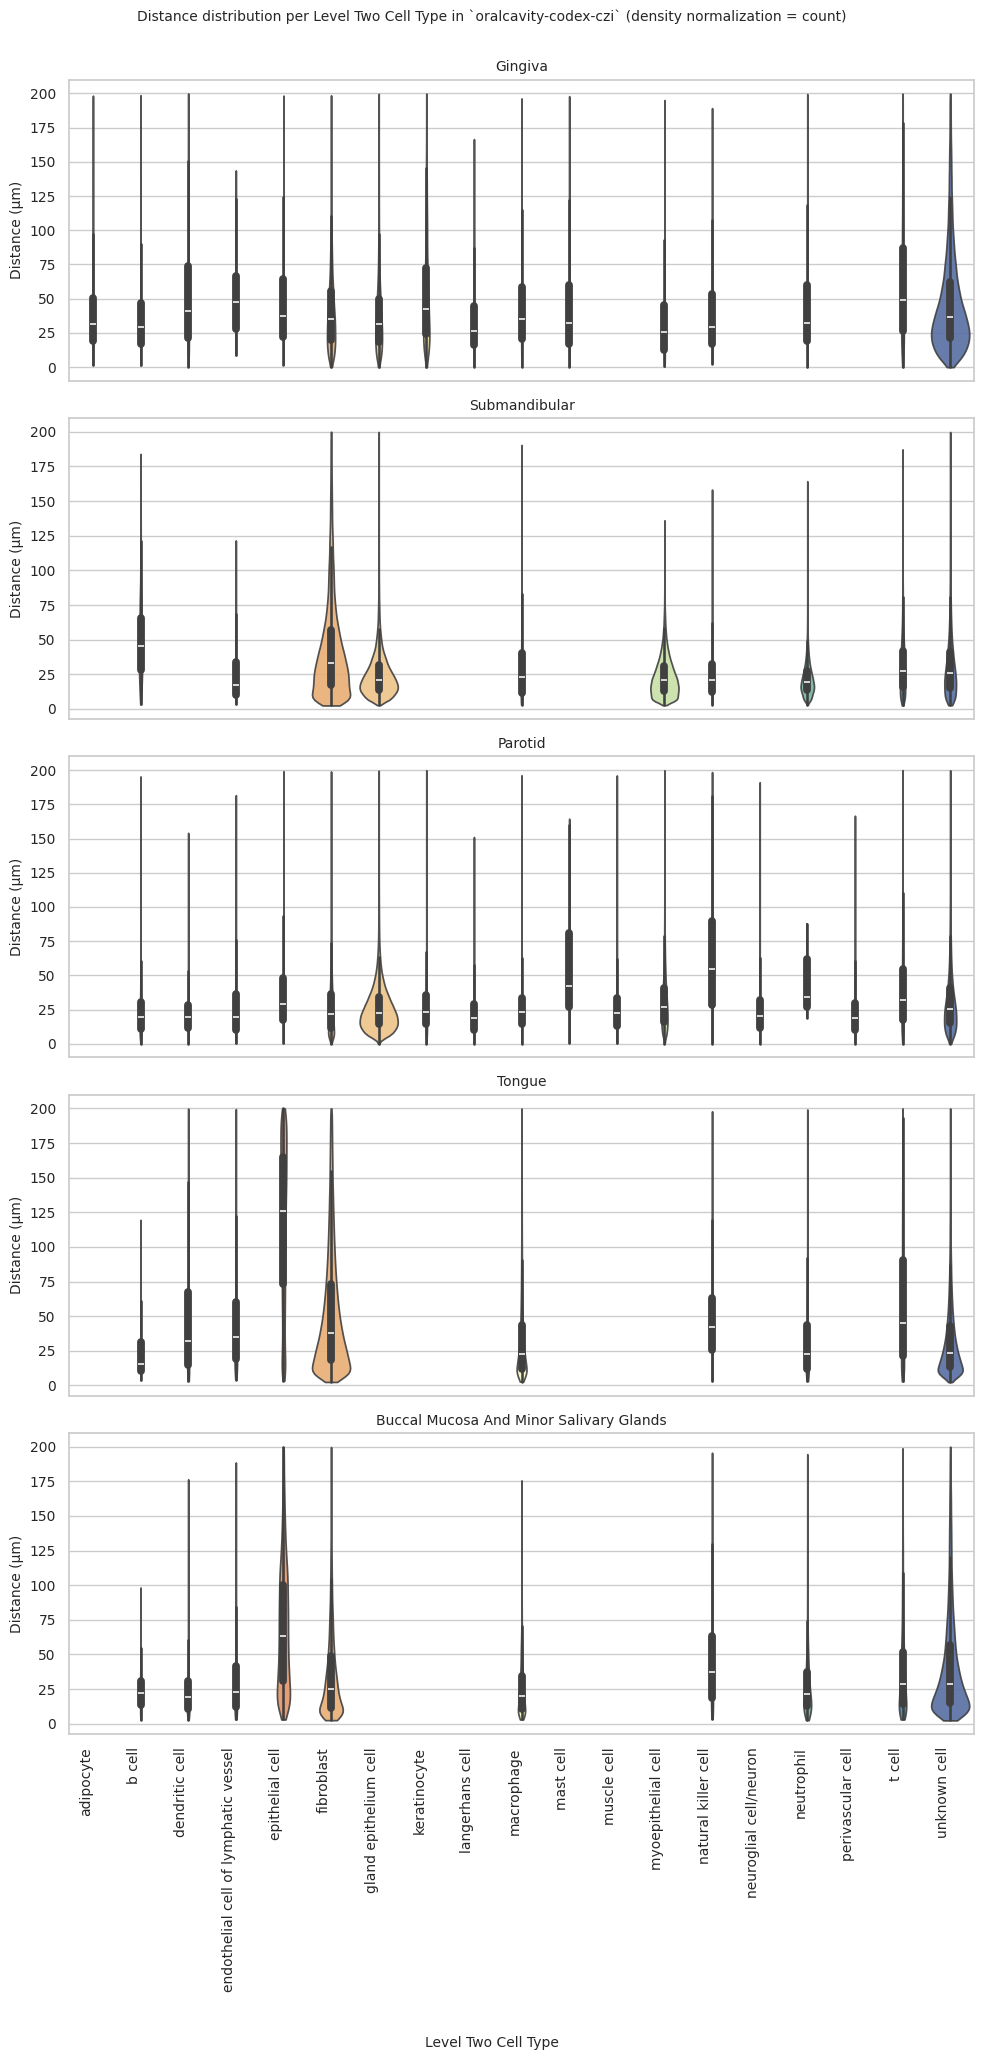

In [40]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

### Level Three Cell Type Analysis

In [41]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,acinar cell of salivary gland,Gingiva,36.739726,30.877582,0.029614,198.327899
1,acinar cell of salivary gland,Parotid,26.180957,22.977472,0.017954,199.271997
2,acinar cell of salivary gland,Submandibular,25.430226,22.379846,3.106445,198.710172
3,adipocyte,Gingiva,38.921484,31.576881,1.472765,198.358252
4,b cell,Buccal Mucosa And Minor Salivary Glands,23.196496,22.353669,2.804015,98.284549
5,b cell,Gingiva,38.913598,29.370338,1.271453,198.729570
6,b cell,Parotid,24.002071,20.842505,0.004528,194.426806
7,b cell,Submandibular,49.468888,45.465234,3.304921,184.012207
8,b cell,Tongue,23.064363,15.471976,3.696282,119.542137
9,dendritic cell,Buccal Mucosa And Minor Salivary Glands,23.820644,19.333714,2.753634,176.453535


In [42]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in Buccal Mucosa And Minor Salivary Glands:
   Level Three Cell Type  mean_distance
3        epithelial cell      69.005527
6    natural killer cell      46.769140
11          unknown cell      42.374333
10     t cell:regulatory      40.665551
8            t cell:cd4+      38.785521

Bottom 5 cell types in Buccal Mucosa And Minor Salivary Glands:
                  Level Three Cell Type  mean_distance
2  endothelial cell of lymphatic vessel      31.266348
7                            neutrophil      30.028958
5                            macrophage      25.882874
1                        dendritic cell      23.820644
0                                b cell      23.196496

Top 5 cell types in Gingiva:
                   Level Three Cell Type  mean_distance
16                           t cell:cd8+      64.303943
8                           keratinocyte      53.520737
3                         dendritic cell      53.327090
4   endothelial cell of lymphatic vessel      51.

In [43]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in Buccal Mucosa And Minor Salivary Glands:
   Level Three Cell Type  median_distance
3        epithelial cell        63.242607
6    natural killer cell        37.025667
10     t cell:regulatory        30.033398
8            t cell:cd4+        29.526032
11          unknown cell        28.831450

Bottom 5 cell types in Buccal Mucosa And Minor Salivary Glands:
                  Level Three Cell Type  median_distance
2  endothelial cell of lymphatic vessel        23.013311
0                                b cell        22.353669
7                            neutrophil        21.579446
5                            macrophage        20.110103
1                        dendritic cell        19.333714

Top 5 cell types in Gingiva:
                   Level Three Cell Type  median_distance
16                           t cell:cd8+        52.379107
4   endothelial cell of lymphatic vessel        47.521442
8                           keratinocyte        42.797847
3                

In [44]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                                          mean    std  CV (%)
Unique Region                                                
Buccal Mucosa And Minor Salivary Glands  41.16  37.14    90.2
Gingiva                                  46.82  36.63    78.2
Parotid                                  28.23  21.27    75.3
Submandibular                            30.94  26.10    84.4
Tongue                                   48.57  44.56    91.7

Cell Type Variability Analysis (sorted by CV):
                                                  mean    std  CV (%)
Level Three Cell Type                                                
dendritic cell                                   37.36  37.48   100.3
macrophage                                       32.99  31.34    95.0
myofibroblast                                    36.72  33.92    92.4
t cell:cd8+   

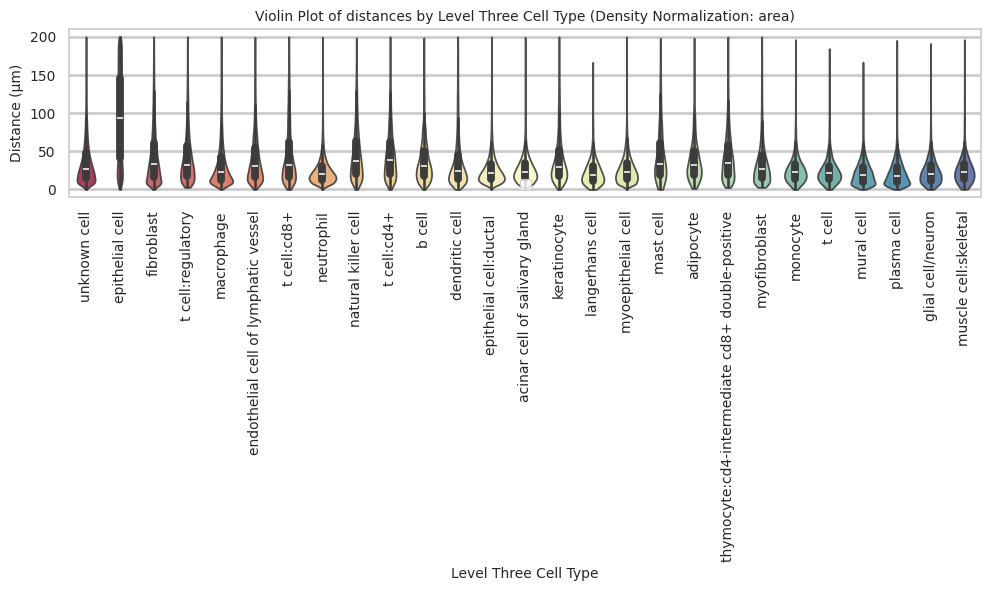

In [45]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

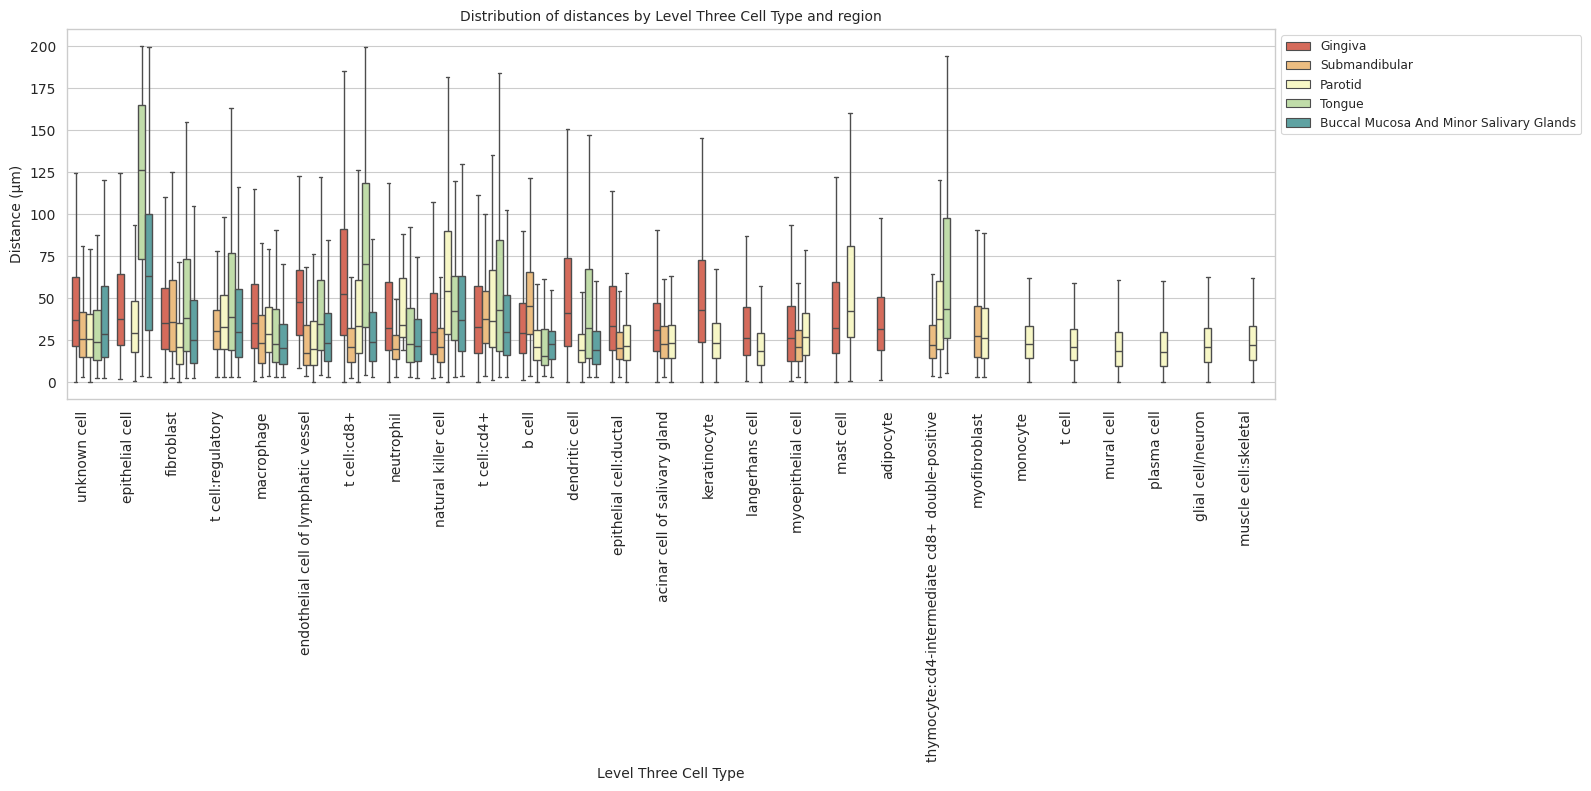

In [46]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

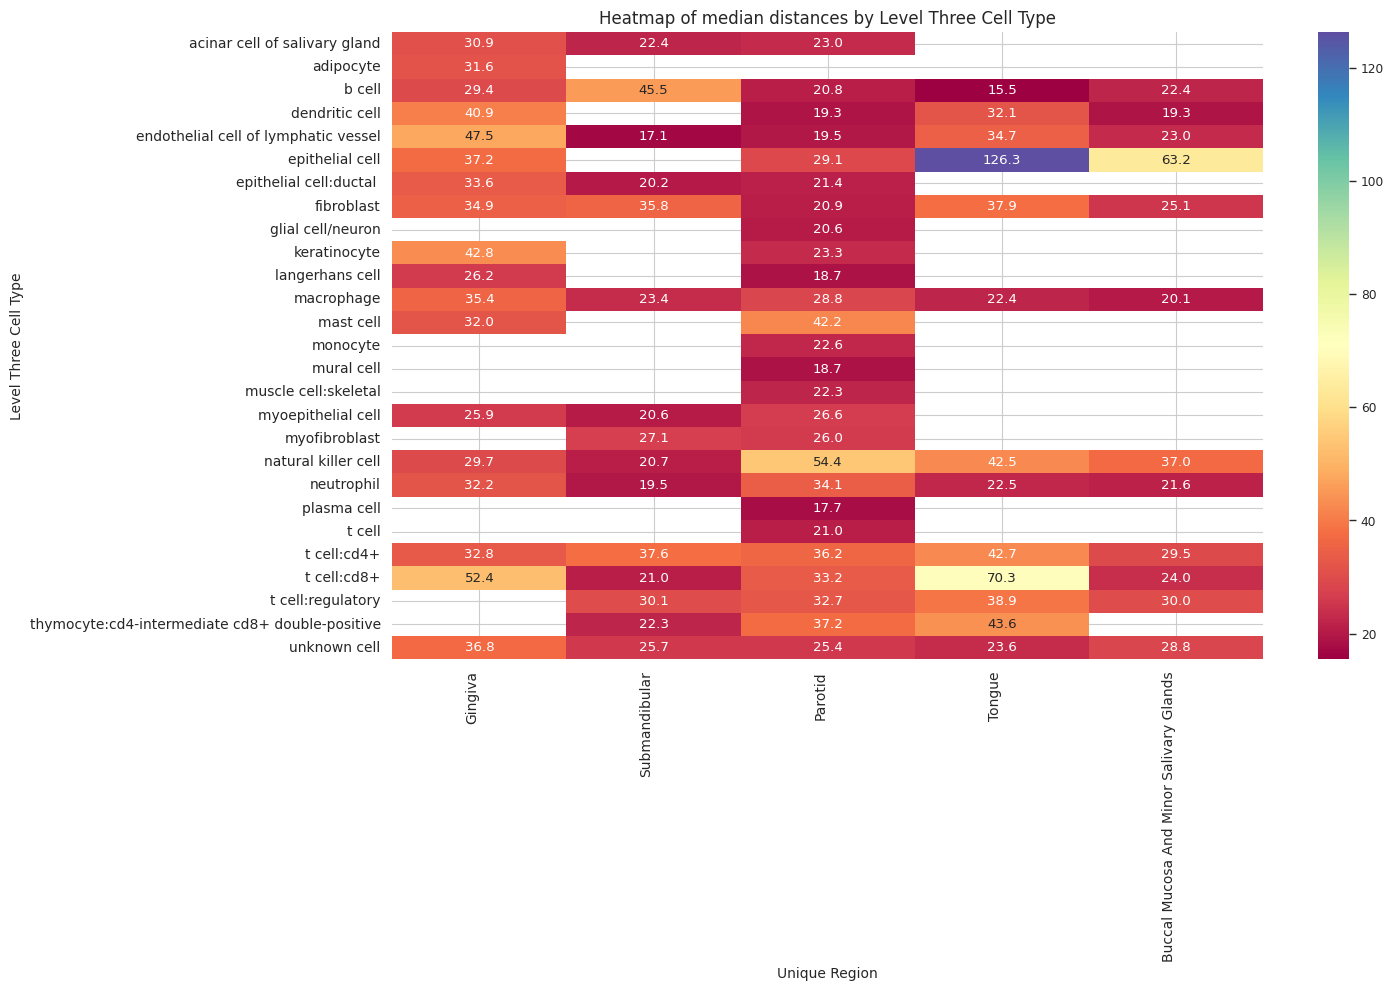

In [47]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

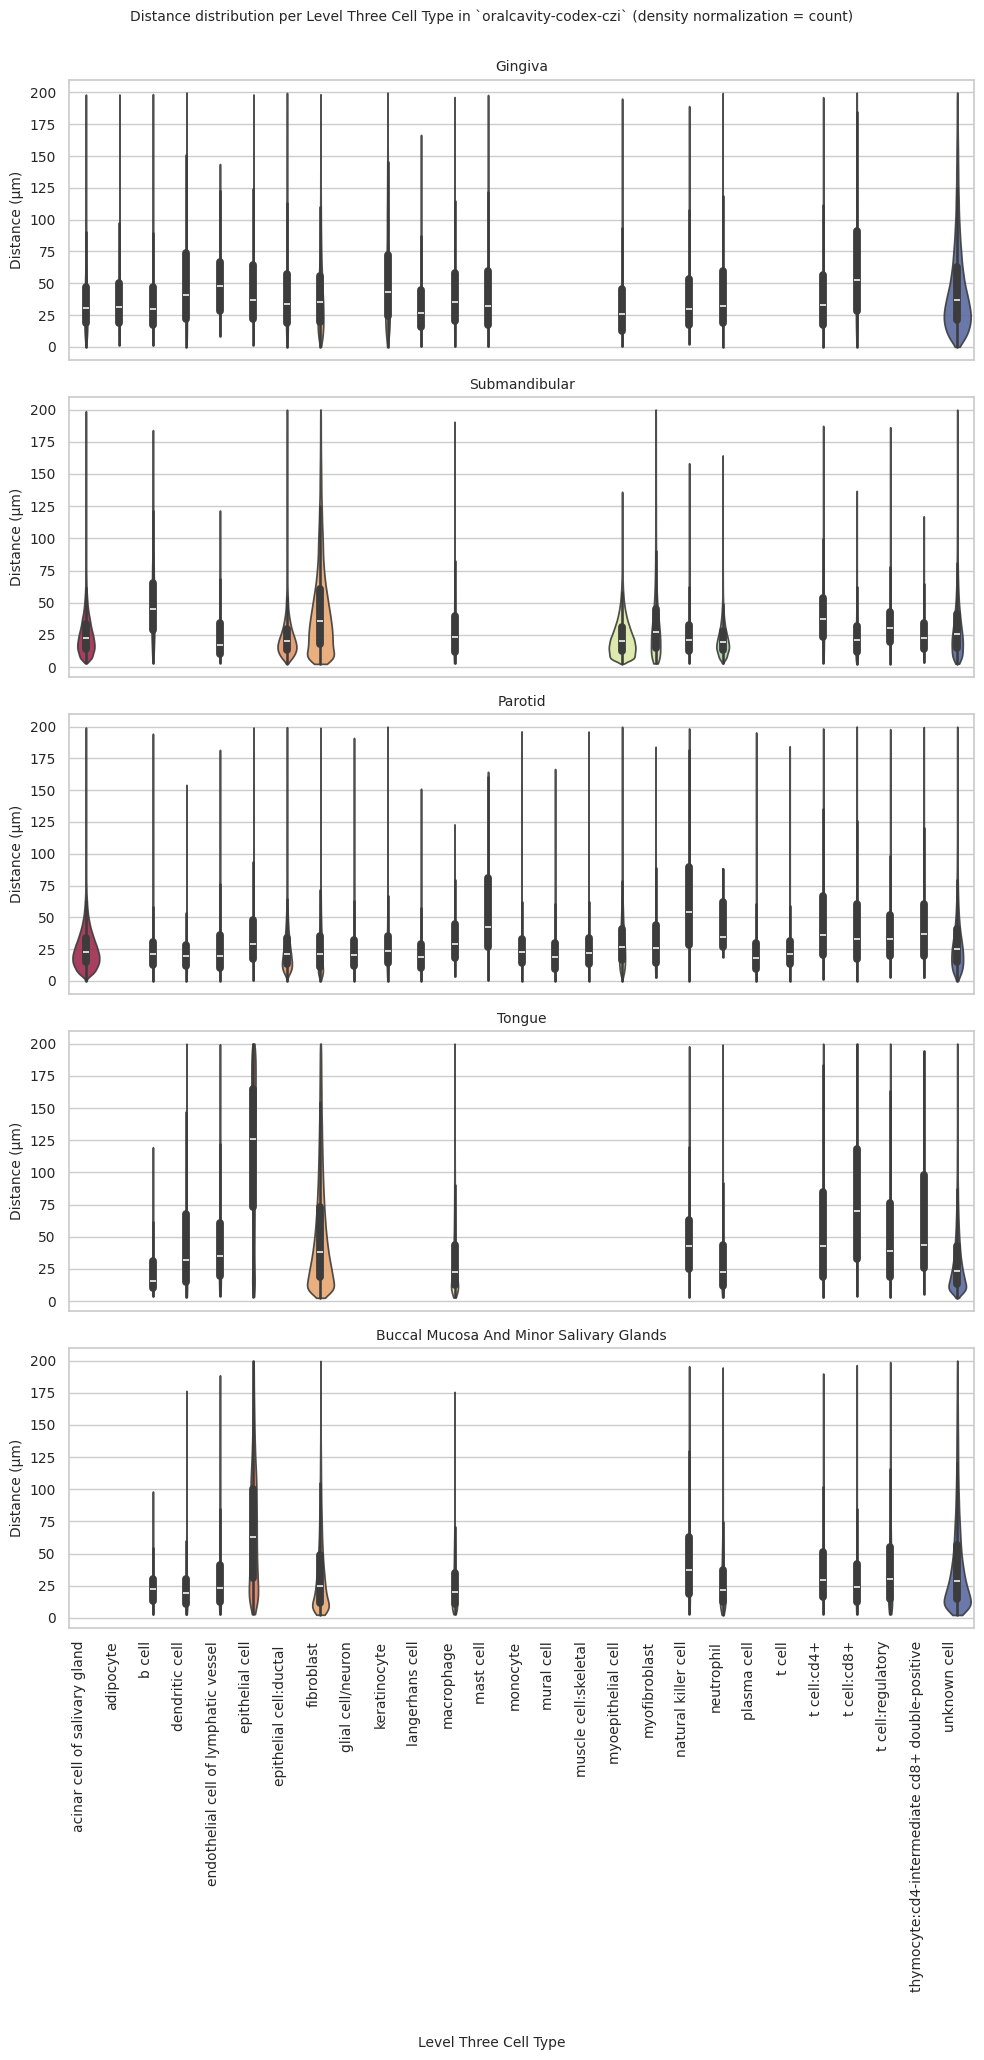

In [48]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.